# Starting with Bokeh
In this notebook the first functions to manipulate Bokeh


In [1]:
import numpy as np
import pandas as pd
from bokeh.plotting import figure, show, output_file

from bokeh.io import show
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper,
    BasicTicker,
    PrintfTickFormatter,
    ColorBar,
)


import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Data pre-processing
data = pd.read_csv('data/data_elog_eindhoven.csv', sep = ';')
# Delete columns
to_delete = ['Unnamed: 0', 'index']
data.drop(to_delete, axis=1, inplace=True)

#Sorth the data
data.sort_values(['location', 'UTC_time' ], ascending=[True, True], inplace=True)
def calculate_diff(data): 
    def diff_func(df): return df.diff()
    data['delta_total'] = data.groupby('location')['total'].apply(diff_func)
    
    return data.reset_index(drop=True)

data = calculate_diff(data)

#Create new varianbles
data['dummy'] = 1
data['datetime64'] = pd.to_datetime(data['UTC_time'])
data['norm_date'] = data['datetime64'].dt.normalize()
data['year'] = data['datetime64'].dt.year
data['month'] = data['datetime64'].dt.month
data['day'] = data['datetime64'].dt.day
data['hour'] = data['datetime64'].dt.hour

## Heat-Map for Water Consuption
Vizualization of the average water consuption per hour in different time sections of the day. Only averages where the number pf obsevations $n>H$ are considered (0 otherwise.)

### Data Agegation


In [30]:
def heat_map_mpl(avg_consuption, num_locations, H = 0):
    
    avg_consuption[num_locations < H] = 0
    mask = np.zeros_like(avg_consuption, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(25, 20))
    
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    #cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(avg_consuption, cmap=cmap, linewidths=.5, square= False)
    ax.set_xticks([])
    #mpl.pyplot.savefig('Figures/correlation_Dependent_Independet.png')
    plt.show()


def data_aggregation(data):
    """
    This funtion creates the matrices that will be use to generate the heat maps
    Params:
    data: the elog data set
    Return:
    avg_consuption: Matrix with the average water consuption per time slot (hour)
    """
    # Here we create the matrices that will be shown at the heat-map
    data = data.dropna()
    avg_consuption = data.groupby(by = ['norm_date', 'hour'])['delta_total'].median()
    avg_consuption = avg_consuption.unstack()
    
    
    # Count the number of unique individuals
    num_locations = data.groupby(by = ['norm_date', 'hour'] , as_index=False).apply(lambda x: x.location.nunique()) #This must be cheched, all values are 5
    num_locations = num_locations.unstack()
    
    
    #Test for errors
    assert avg_consuption.shape == num_locations.shape, 'different shapes'

    return avg_consuption.T, num_locations.T

avg_consuption, num_locations = data_aggregation(data)

In [80]:
# Create a file per location
def create_files_HM(data):
    unique_location = data['location'].unique()
    
    for i in unique_location:
        temp_data = data[data['location'] == i]
        avg_consuption, num_locations = data_aggregation(temp_data)
        avg_consuption.to_csv('data/Data_heat_maps/avg_consuption/{}.csv'.format(str(i)))
        num_locations.to_csv('data/Data_heat_maps/num_locations/{}.csv'.format(str(i)))
            
                             
create_files_HM(data)

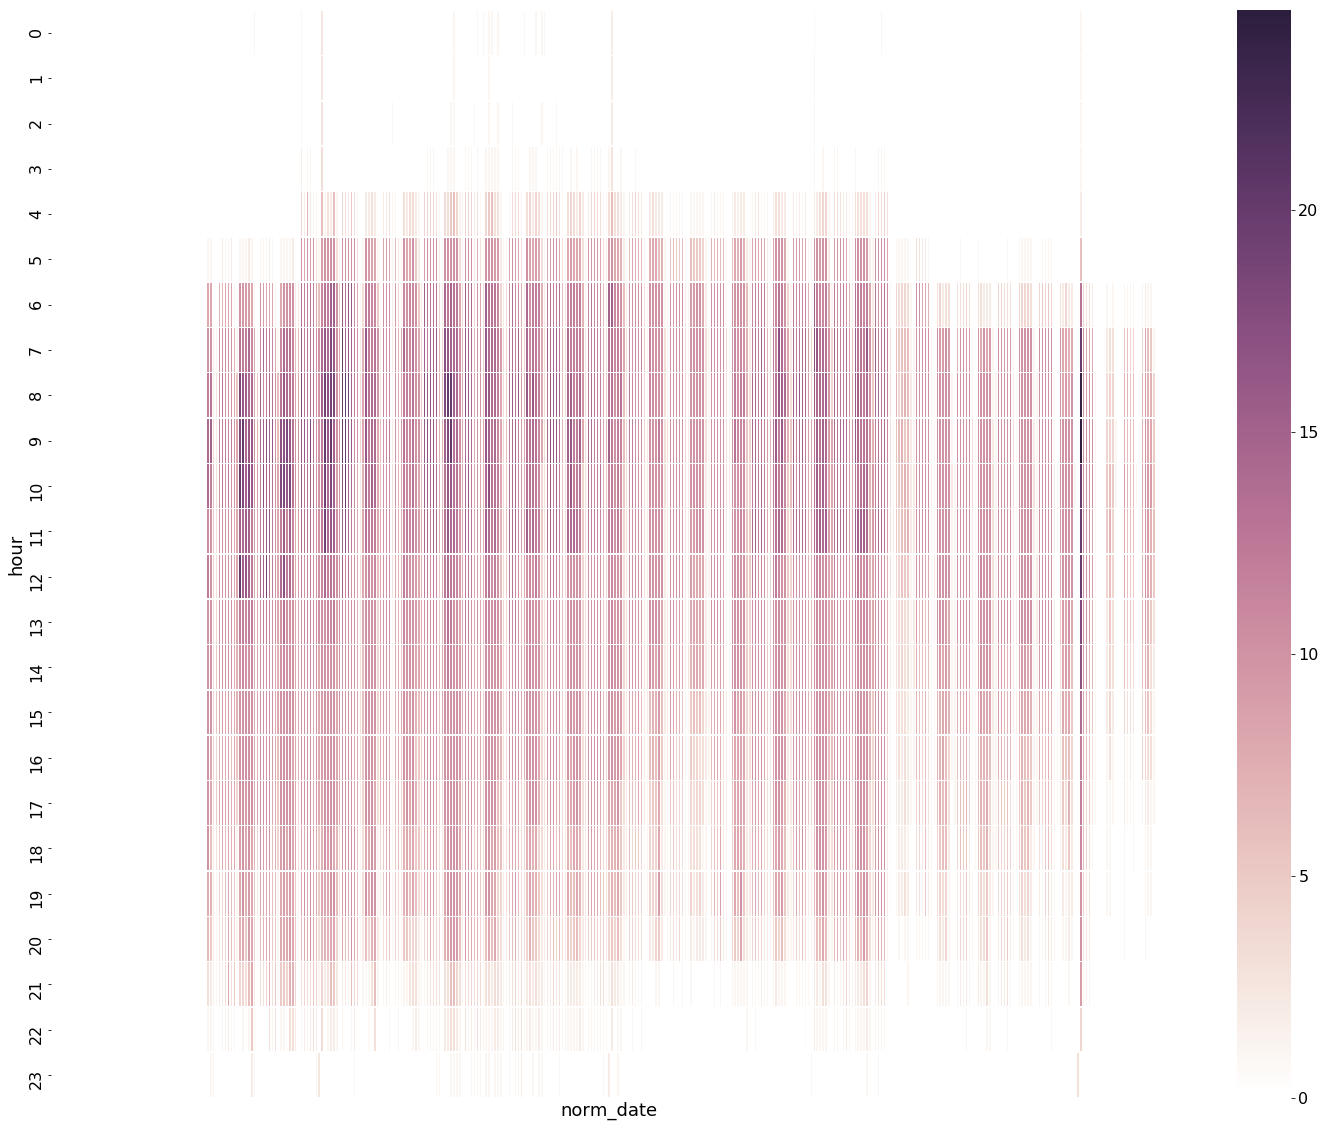

In [77]:
#These heat-maps can be used to spot mystakes
heat_map_mpl(avg_consuption, num_locations, 0)


### Image
Let's the fun have some fun with the Bokeh library


In [6]:
# Simple Image plot, it seems 
def create_heat_map(data):
    #baseed on: https://bokeh.pydata.org/en/latest/docs/gallery/image.html
    x_max = data.shape[1]
    y_man = data.shape[0]
    p = figure(x_range=(0,x_max), y_range=(0,y_man))
    p.image(image=[data.values], x=0, y=0, dw=x_max, dh=y_man, palette="Spectral11")
    output_file("image.html", title="image.py example")
    show(p)

In [7]:
create_heat_map(avg_consuption)

### Iterative scatter plot
from: https://bokeh.pydata.org/en/latest/docs/gallery/color_scatter.html


### Iteractive heat-map
from: http://bokeh.pydata.org/en/latest/docs/gallery/unemployment.html

In [65]:
def iterative_scatter_plot(data, num_locations = None):
    hour = list(data.index.astype(str))
    date = list(data.columns.astype(str))
    
    # reshape to 1D array or rates with a month and year for each row.
    df = pd.DataFrame(data.stack(), columns=['consumption']).reset_index()
    source = ColumnDataSource(df)
    
    

    # Figure creation
    colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
    mapper = LinearColorMapper(palette=colors, low=df.consumption.min(), high=df.consumption.max())
    
    
    TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"
    p = figure(title="Water Consumption Eindhoven ({0} - {1})".format(date[0], date[-1]),
           x_range = date, y_range=list(reversed(hour)),
           x_axis_location="above", plot_width=900, plot_height=400,
           tools=TOOLS, toolbar_location='below')
    
    
    
    p.grid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "5pt"
    p.axis.major_label_standoff = 0
    p.xaxis.major_label_orientation = np.pi / 3


    p.rect(x="norm_date", y="hour", width=1, height=1,
       source=source,
       fill_color={'field': 'consumption', 'transform': mapper},
       line_color=None)
    
    color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="5pt",
                     ticker=BasicTicker(desired_num_ticks=len(colors)),
                     formatter=PrintfTickFormatter(format="%d%%"),
                     label_standoff=6, border_line_color=None, location=(0, 0))
    
    p.add_layout(color_bar, 'right')

    p.select_one(HoverTool).tooltips = [
         ('date', '@Month @Year'),
         ('rate', '@consumption'),
    ]
    
    show(p) 
    
    
iterative_scatter_plot(avg_consuption)

E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: date, rate [renderer: GlyphRenderer(id='d71e4711-8341-4b0f-8bd3-fd0bc329d439', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: date, rate [renderer: GlyphRenderer(id='404d8eb3-9a0e-4120-84b5-54c7e6824910', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: date, rate [renderer: GlyphRenderer(id='5a78a0e6-2cb8-41a8-9846-07b439cae399', ...)]
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: date, rate [renderer: GlyphRenderer(id='64cd219a-2b7e-4d4c-9906-4c9d5577790e', ...)]
W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure(id='a5e3579f-640a-499b-bc07-603c54e72462', ...)
W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure(id='af68f855-e067-4766-8c8f-5e7de5ce81ab', ...)
E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: date [renderer: GlyphRenderer(id='ac7bd622-2c49-4245-9319-17b361c189de', ...)]
E-1001 (BAD_COLUMN_NAME)